In [1]:
import os
import tempfile

import anndata as ad
import muon
import numpy as np
import scanpy as sc
import seaborn as sns
import torch
import muon as mu
import pertpy as pt
import pandas as pd
import re
import torch

from _quasiSCVI import QuasiSCVI
from _quasivae import QuasiVAE


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import scvi
print(scvi.__version__)


1.1.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
# Load the .h5ad file
adata = ad.read_h5ad('/Users/ismail/thesis/Baf single gene guide qc lm.h5ad')

# Display the object
print(adata)


AnnData object with n_obs × n_vars = 38328 × 1289
    obs: 'n_genes', 'batch', 'cell', 'control', 'guide.compact', 'gene.compact', 'unassigned', 'n_genes_by_counts', 'total_counts_mt', 'leiden', 'cell_state', 'SS18_4', 'BCL7A_4', 'SMARCE1_4', 'SS18L_1', 'BCL7B_2', 'SMARCA4_5', 'ARID2_3', 'SMARCD3_3', 'SMARCA2_1', 'BRD9_4', 'GLTSCR1_4', 'SMARCC2_3', 'SS18L_3', 'PHF10_3', 'NTC2_IG216151', 'DPF2_3', 'SS18L_2', 'ARID2_2', 'BCL7C_2', 'PBRM1_3', 'BCL7A_2', 'ARID2_1', 'BCL7B_3', 'GLTSCR1L_4', 'SMARCC2_2', 'SMARCA2_2', 'BRD7_4', 'DPF3_3', 'SMARCB1_5', 'BRD9_2', 'ARID2_4', 'GLTSCR1L_2', 'PHF10_4', 'SMARCA4_1', 'SMARCA4_4', 'ACTL6A_2', 'SS18L_4', 'BCL7B_4', 'SMARCD2_4', 'SMARCD1_2', 'NTC7_IG1144056', 'DPF3_2', 'SMARCA4_7', 'BRD7_3', 'BCL7B_1', 'DPF1_2', 'SMARCD2_2', 'ARID1A_2', 'PHF10_2', 'SMARCC1_7', 'NTC5_mNTC100A67005', 'BCL7A_3', 'SMARCD2_1', 'SMARCD2_3', 'SMARCE1_2', 'BCL7C_3', 'SMARCB1_7', 'BRD7_2', 'SS18_3', 'ACTL6B_1', 'BRD9_1', 'ACTL6A_1', 'SMARCC1_1', 'PBRM1_2', 'ARID1B_4', 'GLTSCR1_1'

In [5]:
adata.obs

,n_genes,batch,cell,control,guide.compact,gene.compact,unassigned,n_genes_by_counts,total_counts_mt,leiden,...,.P2,.P3,.P4,.P5,.P6,.P7,.P8,.P9,.P10,.P11
TTGCATTTCGGTAGAG-1-8,4364,8,0.0,0.0,SMARCA2_3,SMARCA2,0,4364,1777.0,2,...,0.209884,0.091023,-0.079784,-0.052859,-0.023871,-0.106268,-0.065490,-0.093925,-0.138877,-0.126892
TTTGGTTGTAGGTTTC-1-6,4523,6,0.0,0.0,unassigned,unassigned,1,4523,1697.0,4,...,0.303646,0.034636,-0.066206,-0.037091,-0.135707,-0.066927,-0.108650,-0.121789,-0.145670,-0.134484
CACGTGGCAGGCATGA-1-8,3016,8,0.0,0.0,BCL7B_1,BCL7B,0,3016,896.0,5,...,-0.274533,0.024449,0.149817,-0.087757,-0.088601,-0.031453,-0.077011,-0.125244,-0.046160,-0.135437
ACCAAACGTTGAAGTA-1-12,5928,12,0.0,0.0,unassigned,unassigned,1,5928,2412.0,3,...,-0.158908,0.048270,-0.066180,-0.016550,-0.008066,-0.044271,-0.119790,-0.104319,-0.118289,-0.167694
CTCAGAAAGACTCTAC-1-11,4594,11,0.0,0.0,ACTL6B_4,ACTL6B,0,4594,1859.0,1,...,0.190171,-0.011801,-0.069991,-0.067258,-0.045424,-0.100850,-0.142342,-0.088255,-0.152857,-0.147155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGAAGCGTCAGGACGA-1-9,4964,9,0.0,0.0,PBRM1_4,PBRM1,0,4963,2287.0,3,...,-0.124360,0.092573,-0.120545,-0.052604,-0.071641,-0.061278,-0.111678,-0.107756,-0.133673,-0.133523
GTTGCGGCAACCCGCA-1-6,6043,6,0.0,0.0,BCL7A_1,BCL7A,0,6043,3493.0,3,...,0.045556,0.042191,-0.087506,-0.045139,-0.055465,0.004878,-0.104217,-0.095756,-0.132171,-0.180121
GGAGATGAGTAGAATC-1-0,3582,0,0.0,0.0,unassigned,unassigned,1,3582,1196.0,0,...,0.312022,0.013156,0.010845,-0.054402,-0.055282,-0.136859,-0.161164,-0.071691,-0.107270,-0.123363
TCTTTGAGTCAGTTTG-1-6,4472,6,0.0,0.0,SS18_3,SS18,0,4472,1646.0,4,...,0.304349,0.027444,-0.038663,-0.064119,-0.075211,-0.041830,-0.099594,-0.116923,-0.120978,-0.112966


In [6]:
adata.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std,coef.gene2.program,coef.gene2.program_color,new_program,new_program.color
MUC1,15025,False,15025,0.347607,73.686054,19848.0,True,0.165828,-0.308917,0.504095,1.732787e-11,0.237323,9,#fc8d62,P7,#66c2a5
CCR1,7732,False,7732,0.177831,86.458607,10154.0,True,0.093780,0.003922,1.731725,1.279599e-11,0.193050,7,#b3b3b3,P11,#fc8d62
RBKS,4499,False,4499,0.088460,92.120703,5051.0,True,0.047697,-0.285813,0.594757,-2.428771e-11,0.132941,7,#b3b3b3,P11,#fc8d62
F3,25422,False,25422,0.945831,55.477329,54006.0,True,0.396673,0.229081,2.783264,-2.281654e-13,0.389663,1,#fc8d62,P3,#8da0cb
TXNIP,33982,False,33982,1.456751,40.485823,83179.0,True,0.583369,0.616224,3.883252,3.586021e-11,0.458277,9,#fc8d62,P7,#66c2a5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MCUB,9540,False,9540,0.204767,83.292177,11692.0,True,0.105099,-0.290108,0.577905,-3.278312e-12,0.194509,9,#fc8d62,P7,#66c2a5
ABCA1,1220,False,1220,0.023976,97.863360,1369.0,True,0.013932,0.017293,1.784193,6.355938e-12,0.075058,6,#e5c494,P9,#e78ac3
FEZ1,3985,False,3985,0.121911,93.020894,6961.0,True,0.074822,0.443046,3.454918,-1.630696e-11,0.191987,6,#e5c494,P9,#e78ac3
NBR1,11367,False,11367,0.245153,80.092471,13998.0,True,0.120634,-0.271094,0.652518,-1.103511e-12,0.204499,9,#fc8d62,P7,#66c2a5


In [7]:
def extract_guide_number(guide):
    if guide == 'unassigned':
        return '0'
    else:
        # Extract the numeric part after the underscore
        match = re.search(r'_(\d+)', guide)
        if match:
            return match.group(1)
        else:
            return np.nan

adata.obs['replicate'] = adata.obs['guide.compact'].apply(extract_guide_number)
adata.obs['replicate'] = adata.obs['replicate'].astype('str')
adata.obs["replicate"]

TTGCATTTCGGTAGAG-1-8     3
TTTGGTTGTAGGTTTC-1-6     0
CACGTGGCAGGCATGA-1-8     1
ACCAAACGTTGAAGTA-1-12    0
CTCAGAAAGACTCTAC-1-11    4
                        ..
AGAAGCGTCAGGACGA-1-9     4
GTTGCGGCAACCCGCA-1-6     1
GGAGATGAGTAGAATC-1-0     0
TCTTTGAGTCAGTTTG-1-6     3
GCTACAAGTATACCCA-1-2     1
Name: replicate, Length: 38328, dtype: object

In [8]:
adata.obs["gene.compact"]

TTGCATTTCGGTAGAG-1-8        SMARCA2
TTTGGTTGTAGGTTTC-1-6     unassigned
CACGTGGCAGGCATGA-1-8          BCL7B
ACCAAACGTTGAAGTA-1-12    unassigned
CTCAGAAAGACTCTAC-1-11        ACTL6B
                            ...    
AGAAGCGTCAGGACGA-1-9          PBRM1
GTTGCGGCAACCCGCA-1-6          BCL7A
GGAGATGAGTAGAATC-1-0     unassigned
TCTTTGAGTCAGTTTG-1-6           SS18
GCTACAAGTATACCCA-1-2        GLTSCR1
Name: gene.compact, Length: 38328, dtype: category
Categories (30, object): ['ACTL6A', 'ACTL6B', 'ARID1A', 'ARID1B', ..., 'SS18', 'SS18L', 'control', 'unassigned']

In [9]:
perturbed_adata = adata[
    adata.obs["gene.compact"] != "unassigned"
]  # Only consider perturbed cells
perturbed_adata.obs


,n_genes,batch,cell,control,guide.compact,gene.compact,unassigned,n_genes_by_counts,total_counts_mt,leiden,...,.P3,.P4,.P5,.P6,.P7,.P8,.P9,.P10,.P11,replicate
TTGCATTTCGGTAGAG-1-8,4364,8,0.0,0.0,SMARCA2_3,SMARCA2,0,4364,1777.0,2,...,0.091023,-0.079784,-0.052859,-0.023871,-0.106268,-0.065490,-0.093925,-0.138877,-0.126892,3
CACGTGGCAGGCATGA-1-8,3016,8,0.0,0.0,BCL7B_1,BCL7B,0,3016,896.0,5,...,0.024449,0.149817,-0.087757,-0.088601,-0.031453,-0.077011,-0.125244,-0.046160,-0.135437,1
CTCAGAAAGACTCTAC-1-11,4594,11,0.0,0.0,ACTL6B_4,ACTL6B,0,4594,1859.0,1,...,-0.011801,-0.069991,-0.067258,-0.045424,-0.100850,-0.142342,-0.088255,-0.152857,-0.147155,4
CATCAAGCAAGCGGAT-1-4,4865,4,0.0,0.0,DPF3_2,DPF3,0,4865,2032.0,6,...,0.083702,-0.101828,0.053535,-0.028463,-0.046678,-0.105566,-0.110459,-0.131653,-0.159632,2
ATTCTTGAGTTTCAGC-1-2,4097,2,0.0,0.0,BCL7B_3,BCL7B,0,4097,1335.0,3,...,0.047590,-0.041850,0.062592,-0.139507,0.079137,-0.095947,-0.136911,-0.075055,-0.138381,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGGATACAATAAGGT-1-8,4504,8,0.0,0.0,BCL7B_3,BCL7B,0,4504,1786.0,0,...,0.108813,-0.109756,-0.078059,-0.038733,-0.153273,-0.102016,-0.092018,-0.135454,-0.137559,3
AGAAGCGTCAGGACGA-1-9,4964,9,0.0,0.0,PBRM1_4,PBRM1,0,4963,2287.0,3,...,0.092573,-0.120545,-0.052604,-0.071641,-0.061278,-0.111678,-0.107756,-0.133673,-0.133523,4
GTTGCGGCAACCCGCA-1-6,6043,6,0.0,0.0,BCL7A_1,BCL7A,0,6043,3493.0,3,...,0.042191,-0.087506,-0.045139,-0.055465,0.004878,-0.104217,-0.095756,-0.132171,-0.180121,1
TCTTTGAGTCAGTTTG-1-6,4472,6,0.0,0.0,SS18_3,SS18,0,4472,1646.0,4,...,0.027444,-0.038663,-0.064119,-0.075211,-0.041830,-0.099594,-0.116923,-0.120978,-0.112966,3


In [10]:
# layer_names = adata.layers.keys()
# print("Layers in AnnData object:", list(layer_names))
# # Inspect each layer's data matrix
# for layer_name in layer_names:
#     print(f"Layer '{layer_name}' data matrix:")
#     print(adata.layers[layer_name])

In [11]:
adata_ref = adata.copy()


In [12]:
QuasiSCVI.setup_anndata(adata_ref, batch_key="batch", layer="counts")

In [13]:
# Initialize the Quasi SCVI model
scvi_ref = QuasiSCVI(
    adata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# Train the model
scvi_ref.train(max_epochs=200, plan_kwargs={"lr": 1e-4})

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|█████████████████████████████████████████| 200/200 [18:44<00:00,  5.34s/it, v_num=1, train_loss_step=66.4, train_loss_epoch=73.6]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█████████████████████████████████████████| 200/200 [18:44<00:00,  5.62s/it, v_num=1, train_loss_step=66.4, train_loss_epoch=73.6]


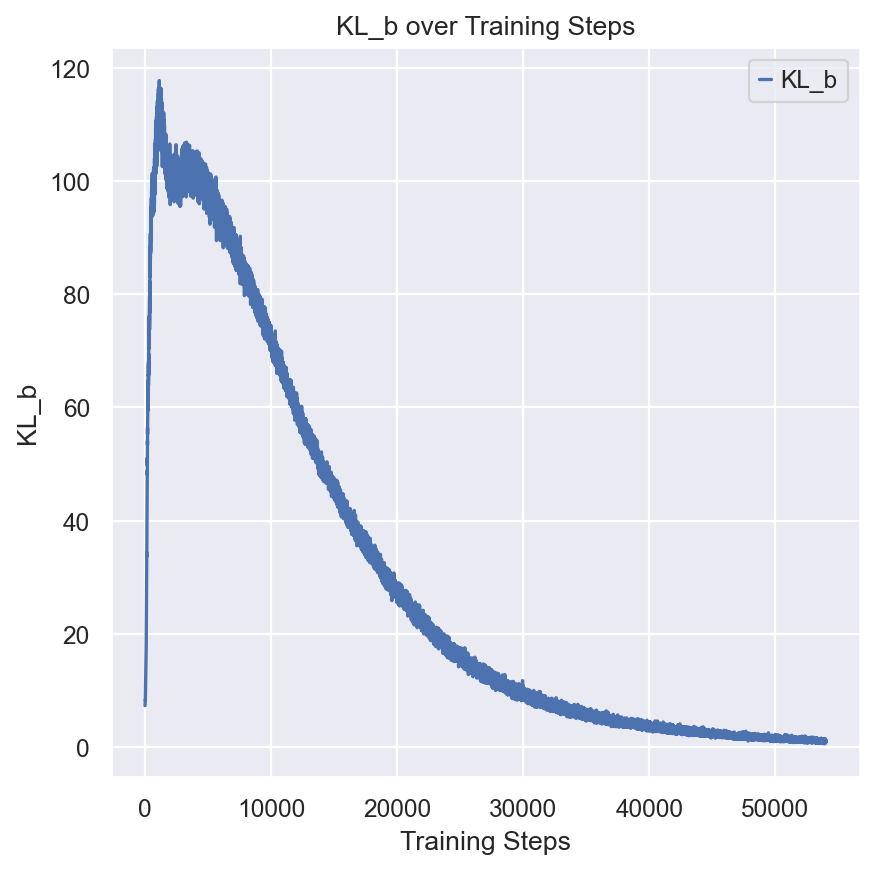

In [15]:
import matplotlib.pyplot as plt

kl_b_values = scvi_ref.module.kl_b_log
plt.plot(kl_b_values, label='KL_b')
plt.xlabel('Training Steps')
plt.ylabel('KL_b')
plt.title('KL_b over Training Steps')
plt.legend()
plt.show()

In [15]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

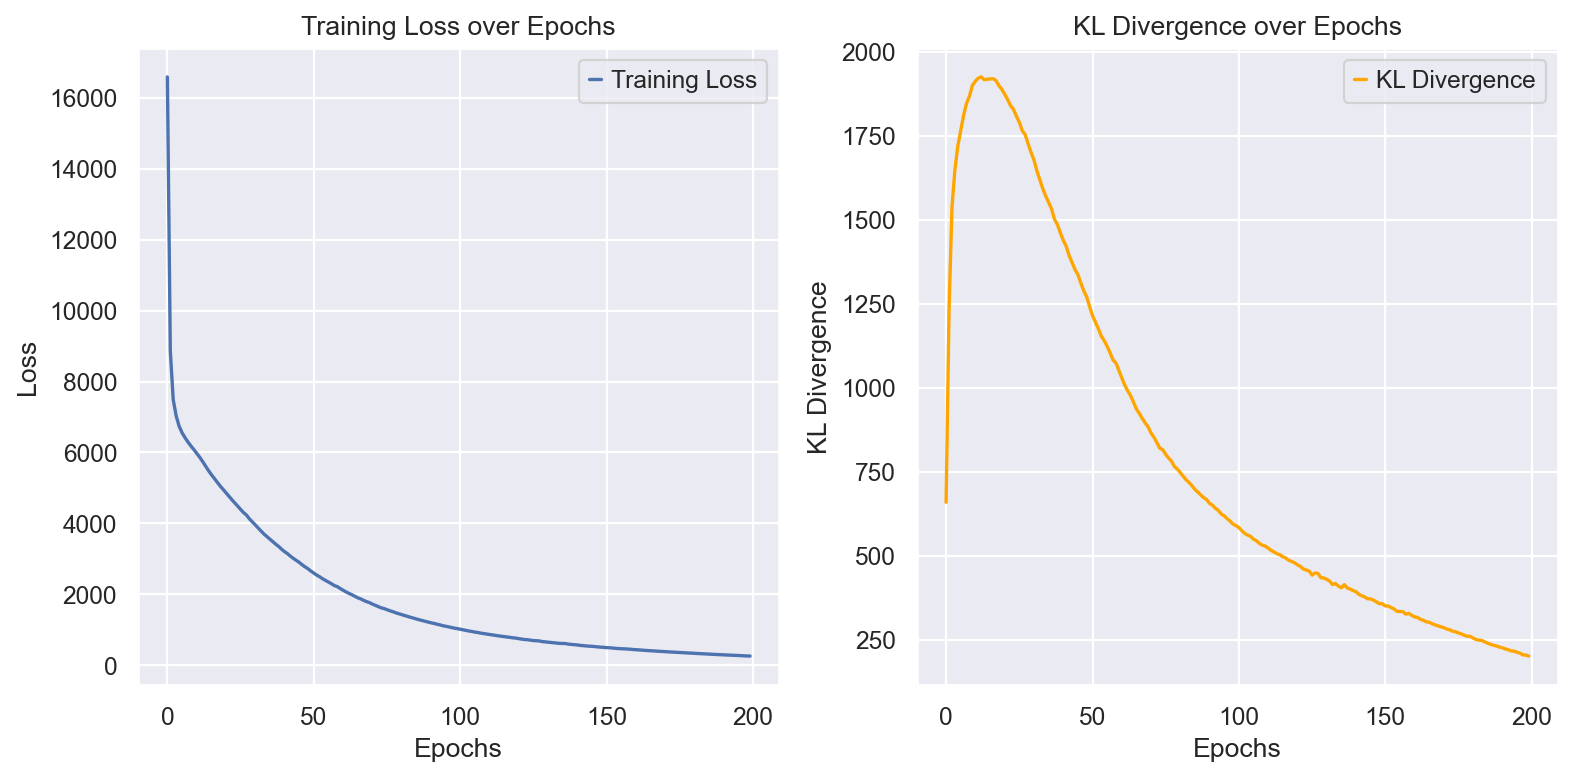

In [16]:
# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
SCVI_LATENT_KEY = "X_scVI"

adata_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_73664/3423007261.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_ref)


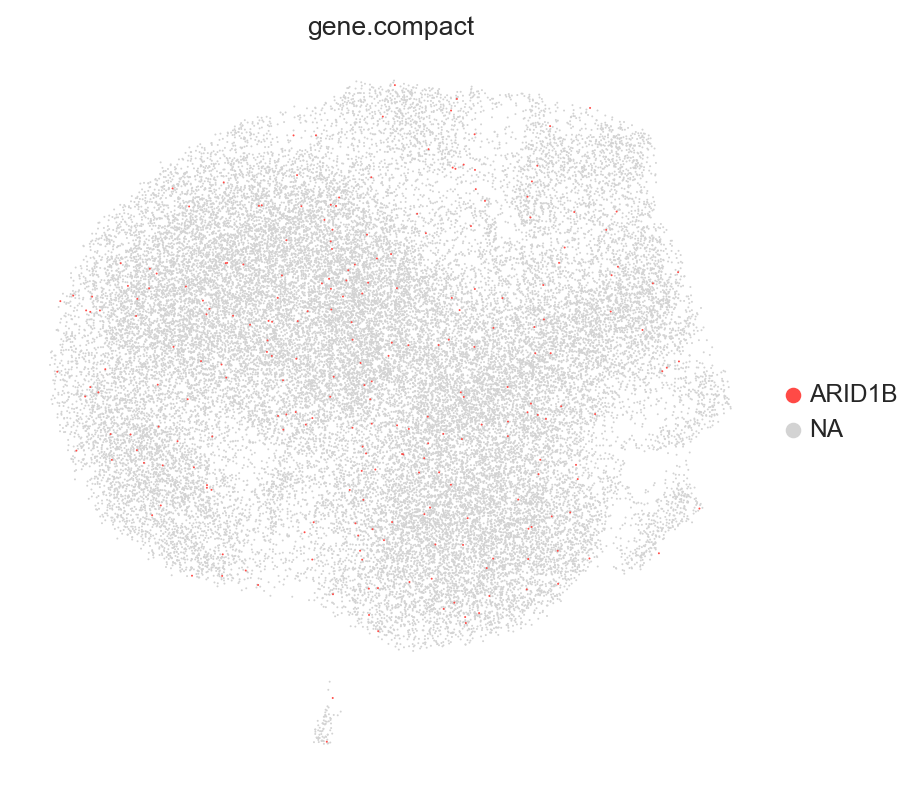

In [18]:
sc.pl.umap(
    adata_ref,
    color=[ "gene.compact"],
    frameon=False,
    ncols=1,
    groups=["ARID1B"]

)

In [20]:
scvi_ref.history["kl_local_train"]

,kl_local_train
epoch,
0,659.038025
1,1231.282349
2,1536.821899
3,1647.695679
4,1718.788208
...,...
195,212.813995
196,210.256927
197,204.97757


In [29]:
selected_guides = ["ARID1A", "SMARCCA4"]
adata_filtered = adata_ref[adata_ref.obs['guide.compact'].isin(selected_guides)]

# Plot the UMAP
sc.pl.umap(
    adata_filtered,
    color=selected_guides,
    frameon=False,
    ncols=1,
)

ZeroDivisionError: division by zero